## Use this ipynb notebook to evaluate the trained models for all the methods.
### All the trained models are already uploaded in the repository to be downloaded. If you want to train the model from scratch, please use the CHAMP_ModelTrainingFinal.ipynb file along with the datasets.

In [2]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from numpy import matlib
import torch
import torch.optim as optim
import torch.nn as nn
from scipy.interpolate import BSpline

from champ_helpers import *


diluent full shape (1097, 19) 
Shape of full ch4 (1097, 1)
shape of available dataset is (339, 16) 339
shape of interpolated dataset is (1097, 16) 1097
(1097, 19)
(1097, 1) (1097,)
torch.Size([1097, 15])
torch.Size([1097, 34]) torch.Size([1097, 1]) torch.Size([1097, 1])


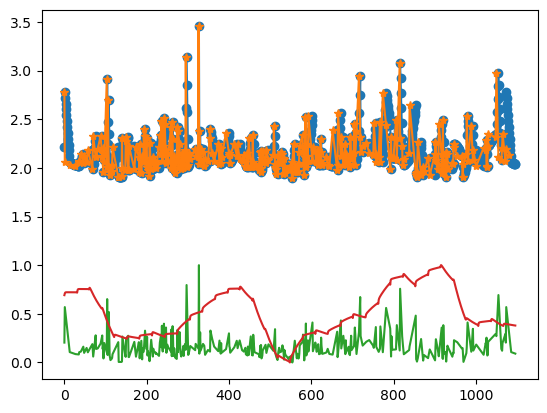

In [3]:
comp = 'Syncrude' #owner of the company Syncrude or Suncor
df_syncrude = company_data(comp) #pd.read_excel(file_path, sheet_name='Syncrude2019-2023')
var = 20 #or 20
year_exp = '2020-2022' #which year data we want 2020, 2021 , 2022, 2023 or 2020-2022
startdate, enddate = year_days(year_exp)
perc = 0.2 #percentage of FFT in the lake under considertaion: 0.2 for MLSB else 0.15
diluent_syncrude = np.array(df_syncrude.iloc[0:])[startdate:enddate,1:var] #+ noise*np.random.normal(0,0.005,(366,var))

dim = diluent_syncrude.shape[1] #dimension of MM solution
num_data = diluent_syncrude.shape[0]-1 #total data points from MM solution


ch4_mat_full = perc*(np.array(df_syncrude.iloc[0:])[startdate:enddate,21]).reshape(-1,1) #ch4 predicted from MMor 21
diluent_full = perc*np.array(diluent_syncrude)

print('diluent full shape', diluent_full.shape,'\nShape of full ch4',ch4_mat_full.shape)
    
station_wbea = 'MLSB' #station name: MLSB, Lower, Mannix
dataset_true, xdays_true = station(station_wbea,year_exp) #days measurements are there
print('shape of available dataset is',dataset_true.shape,len(xdays_true))

interpolate = True
if interpolate == True:
    x = np.array(xdays_true)
    y = np.zeros([dataset_true.shape[0],dataset_true.shape[1]])
    xx = np.linspace(0,diluent_full.shape[0]-1,diluent_full.shape[0])
    dataset_inter = np.zeros((diluent_full.shape[0],dataset_true.shape[1]))
    for i in range(dataset_true.shape[1]):
        y[:,i] = np.array(dataset_true)[:,i]
    spl = BSpline(x, y, 1,extrapolate = 'periodic')
    dataset_inter = spl(xx) 
    
    dataset = dataset_inter
    xdays = list(np.arange(len(xx))[:])
else:
    dataset = dataset_true
    xdays = xdays_true

print('shape of interpolated dataset is',dataset.shape,len(xdays))


plt.plot(dataset[:,0],'-o',label = 'interpolated')
plt.plot(xdays_true,dataset_true[:,0],'-*',label = 'true')


#import data from csv files
year_start = 0
years_end = len(xdays)
percentage = 1.0

diluent = diluent_full[xdays,:]
print(diluent_full.shape)
wbea_pars = dataset[year_start:years_end,1:] #WBEA parameters
ch4_wbea = dataset[year_start:years_end,0] #ch4 in ppm measured by WBEA
ch4_mat = percentage*ch4_mat_full[xdays,:].astype('float32') #ch4 from MM models


print(ch4_mat.shape,ch4_wbea.shape)
#create input data
inp = torch.from_numpy(wbea_pars.astype('float32'))
input_data = percentage*torch.concatenate((inp,torch.tensor(diluent.astype('float32'))),dim = 1) # uses real or 2nd gen diluent data
print(inp.shape)

#scale the input data
scale_inp = np.linalg.norm(input_data[:,:],axis=0)


inp_min = torch.min(input_data,dim=0)[0]
inp_max = torch.max(input_data,dim=0)[0]
input_data = (input_data - inp_min)/(inp_max-inp_min)


#create output data for concentrations taken from real data from WBEA
ch4_conc_data = percentage*torch.from_numpy(ch4_wbea.reshape(-1,1).astype('float32')).reshape(-1,1)

    
scale_out = torch.norm(ch4_conc_data)

out_min = torch.min(ch4_conc_data)
out_max = torch.max(ch4_conc_data)
ch4_conc_data = (ch4_conc_data - out_min)/(out_max-out_min)
plt.plot(ch4_conc_data)

#create output data for emissions taken from MM
ch4_emm_data = percentage*torch.Tensor(ch4_mat).reshape(-1,1) 

scale_emm_data = torch.norm(ch4_emm_data)
ch4_min = torch.min(ch4_emm_data)
ch4_max = torch.max(ch4_emm_data)
ch4_emm_data = (ch4_emm_data - ch4_min)/(ch4_max-ch4_min)
plt.plot(ch4_emm_data)

print(input_data.shape,ch4_conc_data.shape,ch4_emm_data.shape)




In [4]:
#create train-test split

num_train = int(0.8*input_data.shape[0])
num_val = int(0.2*(input_data.shape[0]))


input_train = input_data[:num_train,:]            # contains WBEA variables and lab HCs
ch4_conc_train = ch4_conc_data[:num_train,:]      # from WBEA
ch4_emm = ch4_emm_data[:num_train,:] 


input_val = input_data[num_train:num_train+num_val, :]             
ch4_conc_val = ch4_conc_data[num_train:num_train+num_val, :] 
ch4_emm_val = ch4_emm_data[num_train:num_train+num_val, :] 



print(input_train.shape, ch4_conc_train.shape, ch4_emm.shape)
print(input_val.shape, ch4_conc_val.shape, ch4_emm_val.shape)

# Create time data
time_data = np.array(xdays).reshape(-1,1) 

# Convert time_data to a PyTorch tensor and normalize
time_data = torch.tensor(time_data, dtype=torch.float32)
t_min = torch.min(time_data)
t_max = torch.max(time_data)
time_data  /=t_max

time_train, time_val = time_data[:num_train], time_data[num_train:num_train+num_val]

num_data_train = input_train.shape[0] # number of data points for training data set
num_data_tot = num_data_train

d = int(input_train.shape[1]) # 

input_train = input_train.requires_grad_(True)
input_val = input_val.requires_grad_(True)
time_train = time_train.requires_grad_(True)
time_val = time_val.requires_grad_(True)

torch.Size([877, 34]) torch.Size([877, 1]) torch.Size([877, 1])
torch.Size([219, 34]) torch.Size([219, 1]) torch.Size([219, 1])


## Forward model evaluation

In [5]:
min_var = 19 #or 19

In [6]:
input_dim = d
neurons = 500
neurons2 = 200
n_dims = 1

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_data.size(1)+1, neurons, bias=True)
        self.lin2 = nn.Linear(neurons, neurons, bias=True)
        self.lin22 = nn.Linear(neurons, neurons, bias=True)
        self.lin222 = nn.Linear(neurons, neurons, bias=True)
        self.lin3 = nn.Linear(neurons, n_dims, bias=True)

        self.lin4 = nn.Linear(input_data.size(1)+1-min_var, neurons2, bias=True)
        self.lin44 = nn.Linear(neurons2, neurons2, bias=True)
        self.lin5 = nn.Linear(neurons2, 1, bias=True)

    def forward(self, x, t):

            # Concatenate time with input data
            x_with_time = torch.cat((x[:,:], t), dim=1)

            y = self.lin1(x_with_time).relu()
            y = self.lin2(y).relu()
            y = self.lin22(y).relu()
    #         y = self.lin222(y).relu()

            ch4_conc = self.lin3(y).abs()

            # Compute the gradient of ch4_conc with respect to time
            ch4_conc_derivative = torch.autograd.grad(outputs=ch4_conc, inputs=t, grad_outputs=torch.ones_like(ch4_conc), create_graph=True)[0]

    #         print(ch4_conc_derivative.shape)
            z = torch.cat((ch4_conc,x[:,:15]),dim = 1)
            z = self.lin4(z).relu()
            z = self.lin44(z).relu()
            grad_J = self.lin5(z).abs()

            if ch4_conc_derivative is None:
                ch4_conc_derivative = torch.zeros_like(t)

            # Add ch4_conc_derivative to input x
            x_with_derivative = ch4_conc_derivative + grad_J

            ch4_emm = x_with_derivative.abs()

            return ch4_conc, ch4_emm

net = Net()

In [7]:
if station_wbea == 'MLSB':
    model_forward = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/MildredLake/net_forward_MLSB_syncrude_2020-2022')
elif station_wbea == 'Mannix':
    model_forward = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/Mannix/net_forward_Mannix_suncor_2020-2022')
else:
    model_forward = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/LowerCamp/net_forward_LowerCamp_suncor_2020-2022')

In [8]:
model_forward.eval()

Net(
  (lin1): Linear(in_features=35, out_features=500, bias=True)
  (lin2): Linear(in_features=500, out_features=500, bias=True)
  (lin22): Linear(in_features=500, out_features=500, bias=True)
  (lin222): Linear(in_features=500, out_features=500, bias=True)
  (lin3): Linear(in_features=500, out_features=1, bias=True)
  (lin4): Linear(in_features=16, out_features=200, bias=True)
  (lin44): Linear(in_features=200, out_features=200, bias=True)
  (lin5): Linear(in_features=200, out_features=1, bias=True)
)

In [9]:
conc_train1, emm_train1  = model_forward(input_train, time_train)
conc_val1, emm_val1  = model_forward(input_val, time_val)

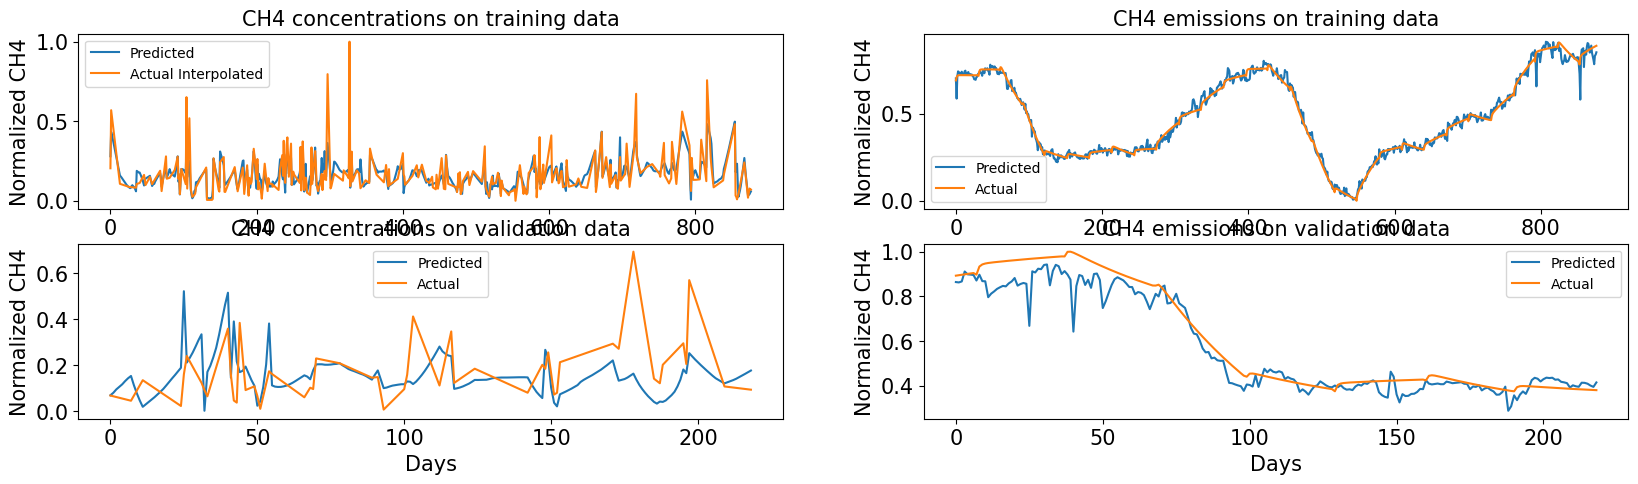

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(2,2,1)
plt.plot(conc_train1.detach().numpy(), label='Predicted')
plt.plot(ch4_conc_train.numpy(), label='Actual Interpolated')
plt.legend()
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.title('CH4 concentrations on training data',fontsize=15)
 
plt.subplot(2,2,2)
plt.plot(emm_train1.detach().numpy()[:], label='Predicted')
plt.plot(ch4_emm.numpy()[:], label='Actual')
plt.legend()
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.title('CH4 emissions on training data',fontsize=15)

plt.subplot(2,2,3)
plt.plot(conc_val1.detach().numpy(), label='Predicted')
plt.plot(ch4_conc_val.numpy(), label='Actual')
plt.legend()
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title('CH4 concentrations on validation data',fontsize=15)

plt.subplot(2,2,4)
plt.plot(emm_val1.detach().numpy(), label='Predicted')
plt.plot(ch4_emm_val.numpy(), label='Actual')
plt.legend()
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
# plt.ylim(0.8,1.05)
plt.title('CH4 emissions on validation data',fontsize=15)

plt.show()

## Reverse model evaluation

In [11]:
input_dim = d
neurons = 500
neurons2 = 200
n_dims = 1
n_dims1 = d+1-min_var #20+1
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.lin1 = nn.Linear(input_dim,neurons,bias = True)
        self.lin2 = nn.Linear(neurons,neurons,bias = True)
        self.lin22 = nn.Linear(neurons,neurons,bias = True)
        self.lin222 = nn.Linear(neurons,neurons,bias = True)
        self.lin3 = nn.Linear(neurons,n_dims,bias = True)
        self.lin4 = nn.Linear(n_dims1,neurons2,bias = True)
        self.lin5 = nn.Linear(neurons2,neurons2,bias = True)
        self.lin6 = nn.Linear(neurons,neurons,bias = True)
        self.lin7 = nn.Linear(neurons2,n_dims,bias = True)
        
    def forward(self, x,t):
        y = self.lin1(x[:,:]).relu()
        y = self.lin2(y).relu()
        y = self.lin3(y)
        ch4_conc = y.abs()
        data_conc = torch.cat((ch4_conc,x[:,:15]),dim = 1)
        z = self.lin4(data_conc).relu()
        z = self.lin5(z).relu()
        z = self.lin7(z)
        ch4_emm = z.abs()
        return ch4_conc,ch4_emm

net = Net()

In [12]:
if station_wbea == 'MLSB':
    model_reverse = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/MildredLake/net_reverse_MLSB_syncrude_2020-2022')
elif station_wbea == 'Mannix':
    model_reverse = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/Mannix/net_reverse_Mannix_suncor_2020-2022')
else:
    model_reverse = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/LowerCamp/net_reverse_LowerCamp_suncor_2020-2022')

In [13]:
model_reverse.eval()

Net(
  (lin1): Linear(in_features=34, out_features=500, bias=True)
  (lin2): Linear(in_features=500, out_features=500, bias=True)
  (lin22): Linear(in_features=500, out_features=500, bias=True)
  (lin222): Linear(in_features=500, out_features=500, bias=True)
  (lin3): Linear(in_features=500, out_features=1, bias=True)
  (lin4): Linear(in_features=16, out_features=200, bias=True)
  (lin5): Linear(in_features=200, out_features=200, bias=True)
  (lin6): Linear(in_features=500, out_features=500, bias=True)
  (lin7): Linear(in_features=200, out_features=1, bias=True)
)

In [14]:
conc_train2, emm_train2  = model_reverse(input_train, time_train)
conc_val2, emm_val2  = model_reverse(input_val, time_val)

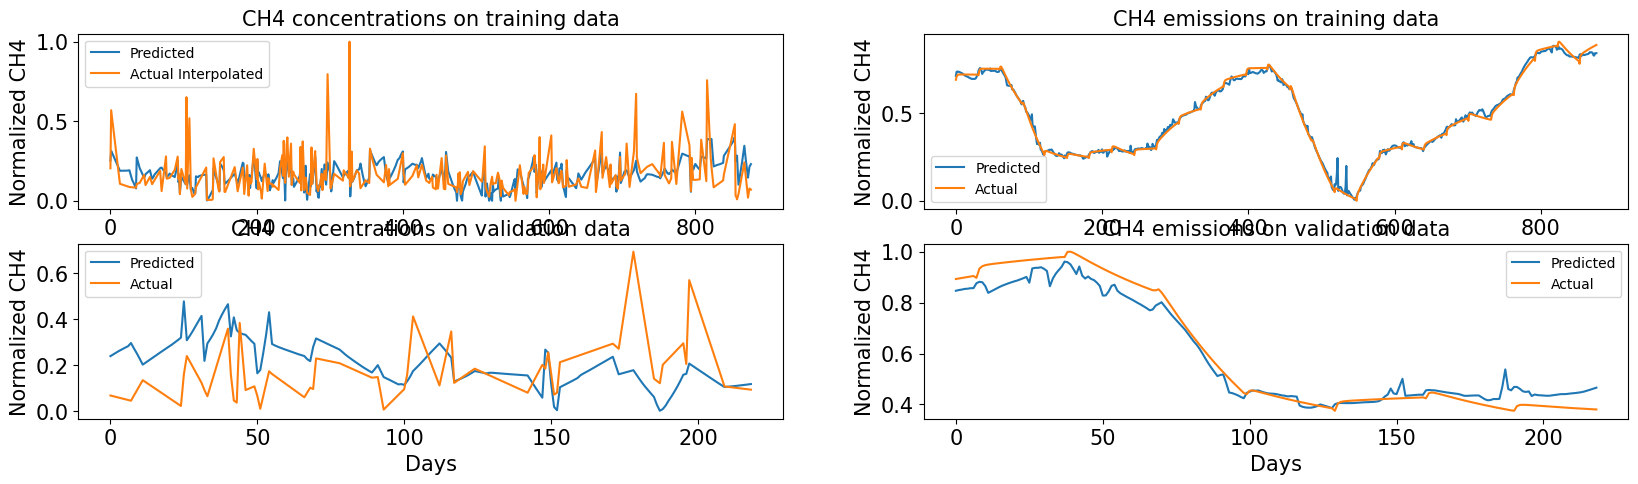

In [15]:
plt.figure(figsize=(20,5))
plt.subplot(2,2,1)
plt.plot(conc_train2.detach().numpy(), label='Predicted')
plt.plot(ch4_conc_train.numpy(), label='Actual Interpolated')
plt.legend()
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.title('CH4 concentrations on training data',fontsize=15)
 
plt.subplot(2,2,2)
plt.plot(emm_train2.detach().numpy()[:], label='Predicted')
plt.plot(ch4_emm.numpy()[:], label='Actual')
plt.legend()
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.title('CH4 emissions on training data',fontsize=15)

plt.subplot(2,2,3)
plt.plot(conc_val2.detach().numpy(), label='Predicted')
plt.plot(ch4_conc_val.numpy(), label='Actual')
plt.legend()
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title('CH4 concentrations on validation data',fontsize=15)

plt.subplot(2,2,4)
plt.plot(emm_val2.detach().numpy(), label='Predicted')
plt.plot(ch4_emm_val.numpy(), label='Actual')
plt.legend()
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
# plt.ylim(0.8,1.05)
plt.title('CH4 emissions on validation data',fontsize=15)

plt.show()

## NN model evaluation

In [16]:
input_dim = d
neurons = 500
n_dims = 2
n_dims1 = d+1-19 #20+1
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.lin1 = nn.Linear(input_dim,neurons,bias = True)
        self.lin2 = nn.Linear(neurons,neurons,bias = True)
        self.lin22 = nn.Linear(neurons,neurons,bias = True)
        self.lin222 = nn.Linear(neurons,neurons,bias = True)
        self.lin3 = nn.Linear(neurons,n_dims,bias = True)
        self.lin4 = nn.Linear(n_dims1,neurons,bias = True)
        self.lin5 = nn.Linear(neurons,neurons,bias = True)
        self.lin6 = nn.Linear(neurons,neurons,bias = True)
        self.lin7 = nn.Linear(neurons,n_dims,bias = False)
        
    def forward(self, x,ch4):
        y = self.lin1(x[:,:]).relu()
        y = self.lin22(y).relu()
        y = self.lin222(y).relu()
        y = self.lin2(y).relu()
        y = self.lin3(y).abs()
        ch4_conc = y[:,0].reshape(-1,1)
        ch4_emm = y[:,1].reshape(-1,1)
        return ch4_conc,ch4_emm

net = Net()

In [17]:
if station_wbea == 'MLSB': 
    model_nn = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/MildredLake/net_NN_MLSB_syncrude_2020-2022')
elif station_wbea == 'Mannix':
    model_nn = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/Mannix/net_NN_Mannix_suncor_2020-2022')   
else:
    model_nn = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/LowerCamp/net_NN_LowerCamp_suncor_2020-2022')


In [18]:
model_nn.eval()

Net(
  (lin1): Linear(in_features=34, out_features=500, bias=True)
  (lin2): Linear(in_features=500, out_features=500, bias=True)
  (lin22): Linear(in_features=500, out_features=500, bias=True)
  (lin222): Linear(in_features=500, out_features=500, bias=True)
  (lin3): Linear(in_features=500, out_features=2, bias=True)
  (lin4): Linear(in_features=20, out_features=500, bias=True)
  (lin5): Linear(in_features=500, out_features=500, bias=True)
  (lin6): Linear(in_features=500, out_features=500, bias=True)
  (lin7): Linear(in_features=500, out_features=2, bias=False)
)

In [19]:
conc_train3, emm_train3  = model_nn(input_train, time_train)
conc_val3, emm_val3  = model_nn(input_val, time_val)

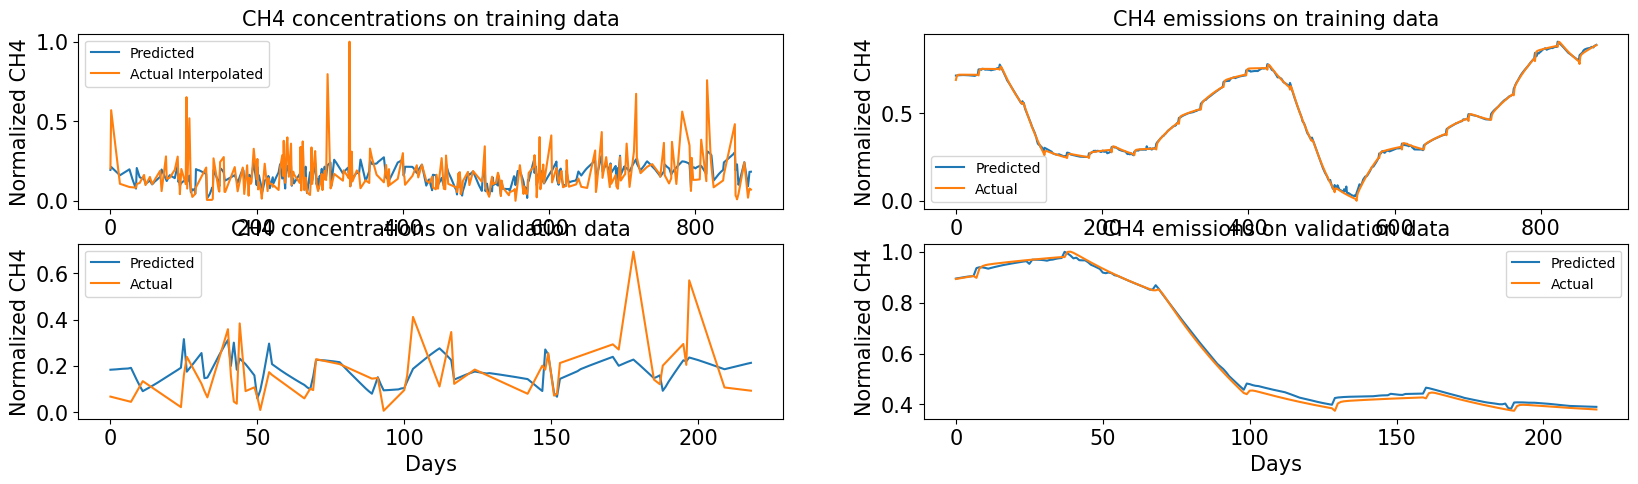

In [20]:
plt.figure(figsize=(20,5))
plt.subplot(2,2,1)
plt.plot(conc_train3.detach().numpy(), label='Predicted')
plt.plot(ch4_conc_train.numpy(), label='Actual Interpolated')
plt.legend()
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.title('CH4 concentrations on training data',fontsize=15)
 
plt.subplot(2,2,2)
plt.plot(emm_train3.detach().numpy()[:], label='Predicted')
plt.plot(ch4_emm.numpy()[:], label='Actual')
plt.legend()
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.title('CH4 emissions on training data',fontsize=15)

plt.subplot(2,2,3)
plt.plot(conc_val3.detach().numpy(), label='Predicted')
plt.plot(ch4_conc_val.numpy(), label='Actual')
plt.legend()
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title('CH4 concentrations on validation data',fontsize=15)

plt.subplot(2,2,4)
plt.plot(emm_val3.detach().numpy(), label='Predicted')
plt.plot(ch4_emm_val.numpy(), label='Actual')
plt.legend()
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
# plt.ylim(0.8,1.05)
plt.title('CH4 emissions on validation data',fontsize=15)

plt.show()

## 1 connect model evaluation

In [21]:
# Assuming these variables are defined elsewhere in your code
input_dim = d
neurons = 500
n_dims = 1

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_data.size(1)+1, neurons, bias=True)
        self.lin2 = nn.Linear(neurons, neurons, bias=True)
        self.lin22 = nn.Linear(neurons, neurons, bias=True)
        self.lin222 = nn.Linear(neurons, neurons, bias=True)
        self.lin3 = nn.Linear(neurons, n_dims, bias=True)
        
        self.lin4 = nn.Linear(1, neurons, bias=True)
        self.lin44 = nn.Linear(neurons, 1, bias=True)
        self.lin5 = nn.Linear(neurons, 1, bias=False)

    def forward(self, x, t):
    
        # Concatenate time with input data
        x_with_time = torch.cat((x[:,:], t), dim=1)
        
        y = self.lin1(x_with_time).relu()
        y = self.lin2(y).relu()
        y = self.lin22(y).relu()

        ch4_conc = self.lin3(y).abs()

        z = self.lin4(ch4_conc).relu()
        z = self.lin44(z).abs()
        ch4_emm = z

        return ch4_conc, ch4_emm

net = Net()

In [22]:
if station_wbea == 'MLSB':
    one_connect = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/MildredLake/net_1connect_MLSB_syncrude_2020-2022')
elif station_wbea == 'Mannix':
    one_connect = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/Mannix/net_1connect_Mannix_suncor_2020-2022')
else:
    one_connect = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/LowerCamp/net_1connect_LowerCamp_suncor_2020-2022')

In [23]:
one_connect.eval()

Net(
  (lin1): Linear(in_features=35, out_features=500, bias=True)
  (lin2): Linear(in_features=500, out_features=500, bias=True)
  (lin22): Linear(in_features=500, out_features=500, bias=True)
  (lin222): Linear(in_features=500, out_features=500, bias=True)
  (lin3): Linear(in_features=500, out_features=1, bias=True)
  (lin4): Linear(in_features=1, out_features=500, bias=True)
  (lin44): Linear(in_features=500, out_features=1, bias=True)
  (lin5): Linear(in_features=500, out_features=1, bias=False)
)

In [24]:
conc_train4, emm_train4  = one_connect(input_train, time_train)
conc_val4, emm_val4  = one_connect(input_val, time_val)

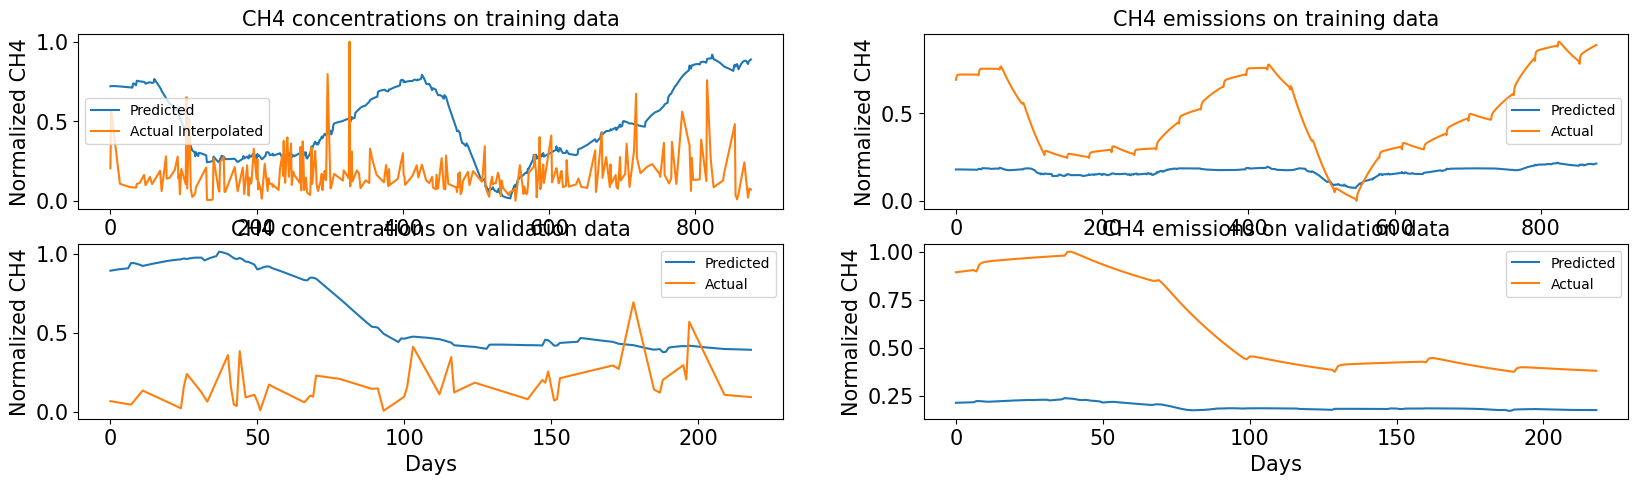

In [25]:
plt.figure(figsize=(20,5))
plt.subplot(2,2,1)
plt.plot(conc_train4.detach().numpy(), label='Predicted')
plt.plot(ch4_conc_train.numpy(), label='Actual Interpolated')
plt.legend()
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.title('CH4 concentrations on training data',fontsize=15)
 
plt.subplot(2,2,2)
plt.plot(emm_train4.detach().numpy()[:], label='Predicted')
plt.plot(ch4_emm.numpy()[:], label='Actual')
plt.legend()
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.title('CH4 emissions on training data',fontsize=15)

plt.subplot(2,2,3)
plt.plot(conc_val4.detach().numpy(), label='Predicted')
plt.plot(ch4_conc_val.numpy(), label='Actual')
plt.legend()
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title('CH4 concentrations on validation data',fontsize=15)

plt.subplot(2,2,4)
plt.plot(emm_val4.detach().numpy(), label='Predicted')
plt.plot(ch4_emm_val.numpy(), label='Actual')
plt.legend()
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
# plt.ylim(0.8,1.05)
plt.title('CH4 emissions on validation data',fontsize=15)

plt.show()

## LSTM model evaluation

In [26]:
input_dim = d
neurons = 100
n_dims = 2
n_dims1 = d+1
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.lstm = nn.LSTM(input_dim, neurons,4)
        self.out = nn.Linear(neurons, n_dims)
        self.lin4 = nn.Linear(n_dims1,neurons,bias = True)
        self.lin5 = nn.Linear(neurons,neurons,bias = True)
        self.lin6 = nn.Linear(neurons,neurons,bias = True)
        self.lin7 = nn.Linear(neurons,n_dims,bias = True)

    def forward(self, x,t):
        y,_ = self.lstm(x[:,:])
        y = self.out(y).abs()
        ch4_conc = y[:,0].reshape(-1,1)
        ch4_emm = y[:,1].reshape(-1,1)
        return ch4_conc,ch4_emm

net = Net()

In [27]:
if station_wbea == 'MLSB':
    model_LSTM = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/MildredLake/net_LSTM_MLSB_syncrude_2020-2022')
elif station_wbea == 'Mannix':
    model_LSTM = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/Mannix/net_LSTM_Mannix_suncor_2020-2022')
else:
    model_LSTM = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/LowerCamp/net_LSTM_LowerCamp_suncor_2020-2022')


In [28]:
model_LSTM.eval()

Net(
  (lstm): LSTM(34, 100, num_layers=4)
  (out): Linear(in_features=100, out_features=2, bias=True)
  (lin4): Linear(in_features=35, out_features=100, bias=True)
  (lin5): Linear(in_features=100, out_features=100, bias=True)
  (lin6): Linear(in_features=100, out_features=100, bias=True)
  (lin7): Linear(in_features=100, out_features=2, bias=True)
)

In [29]:
conc_train5, emm_train5  = model_LSTM(input_train, time_train)
conc_val5, emm_val5  = model_LSTM(input_val, time_val)

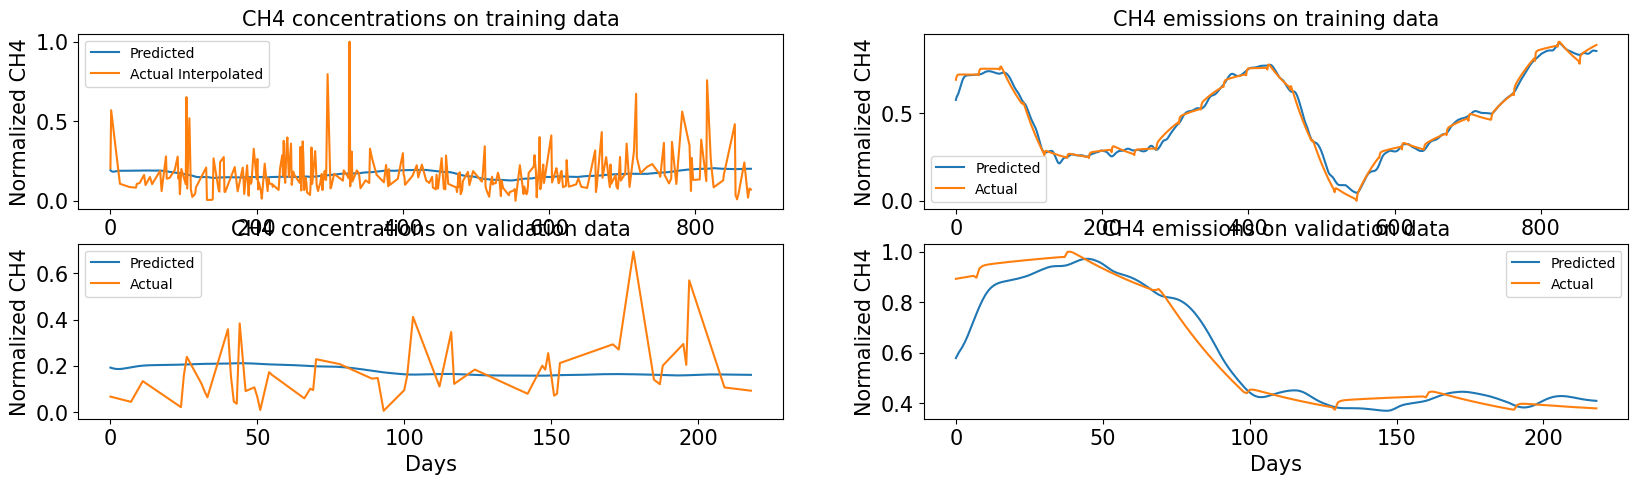

In [30]:
plt.figure(figsize=(20,5))
plt.subplot(2,2,1)
plt.plot(conc_train5.detach().numpy(), label='Predicted')
plt.plot(ch4_conc_train.numpy(), label='Actual Interpolated')
plt.legend()
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.title('CH4 concentrations on training data',fontsize=15)
 
plt.subplot(2,2,2)
plt.plot(emm_train5.detach().numpy()[:], label='Predicted')
plt.plot(ch4_emm.numpy()[:], label='Actual')
plt.legend()
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.title('CH4 emissions on training data',fontsize=15)

plt.subplot(2,2,3)
plt.plot(conc_val5.detach().numpy(), label='Predicted')
plt.plot(ch4_conc_val.numpy(), label='Actual')
plt.legend()
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title('CH4 concentrations on validation data',fontsize=15)

plt.subplot(2,2,4)
plt.plot(emm_val5.detach().numpy(), label='Predicted')
plt.plot(ch4_emm_val.numpy(), label='Actual')
plt.legend()
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
# plt.ylim(0.8,1.05)
plt.title('CH4 emissions on validation data',fontsize=15)

plt.show()

## polydict model evaluation

In [31]:
input_dim = input_data.size(1)
neurons = 200
neurons2 = 500
n_dims = 1
dict_shape = int((d+1+1-min_var)*(d+1+2-min_var)/2)
print(dict_shape)

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_data.size(1)+1, neurons, bias=True)
        self.lin2 = nn.Linear(neurons, neurons, bias=True)
        self.lin22 = nn.Linear(neurons, neurons, bias=True)
        self.lin222 = nn.Linear(neurons, neurons, bias=True)
        self.lin3 = nn.Linear(neurons, n_dims, bias=True)

        self.lin4 = nn.Linear(input_data.size(1)+1, neurons2, bias=True)
        self.lin44 = nn.Linear(neurons2, neurons2, bias=True)
        self.lin5 = nn.Linear(neurons2, 1, bias=False)

        self.dictlin = nn.Linear(dict_shape, 1, bias=False)

    def forward(self, x, t):

        # Concatenate time with input data
        x_with_time = torch.cat((x[:,:], t), dim=1)

        y = self.lin1(x_with_time).tanh()
        y = self.lin2(y).tanh()
        y = self.lin22(y).tanh()

        ch4_conc = self.lin3(y).abs()

        # Compute the gradient of ch4_conc with respect to time
        ch4_conc_derivative = torch.autograd.grad(outputs=ch4_conc, inputs=t, grad_outputs=torch.ones_like(ch4_conc), create_graph=True)[0]

        z = torch.cat((ch4_conc,x[:,:15]),dim = 1)
        grad_J = dictionarypoly(z.detach().numpy(),'2')
        grad_J = self.dictlin(grad_J).abs()

#         print(grad_J.shape)

        if ch4_conc_derivative is None:
            ch4_conc_derivative = torch.zeros_like(t)

        x_with_derivative = (ch4_conc_derivative + grad_J).abs()

        ch4_emm = x_with_derivative

        return ch4_conc, ch4_emm

# Initialize the neural network
net = Net()

153


In [32]:
if station_wbea == 'MLSB':
    model_polydict = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/MildredLake/net_forwardSparsePolydict_MLSB_syncrude_2020-2022')
#     model_polydict = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/SecondGen/net_forward_SparsePolydicSecGen_2020-2022')

elif station_wbea == 'Mannix':
    model_polydict = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/Mannix/net_SparsePolydict_Mannix_suncor_2020-2022')
else:
    model_polydict = torch.load('/Users/eshasaha/Desktop/ILMEE Postdoc Research Projects/NSERC Alliance P1-P2/HybridModel/Results/LowerCamp/net_forward_SparsePolydicLowerCamp_suncor_2020-2022')

In [33]:
model_polydict.eval()

Net(
  (lin1): Linear(in_features=35, out_features=200, bias=True)
  (lin2): Linear(in_features=200, out_features=200, bias=True)
  (lin22): Linear(in_features=200, out_features=200, bias=True)
  (lin222): Linear(in_features=200, out_features=200, bias=True)
  (lin3): Linear(in_features=200, out_features=1, bias=True)
  (lin4): Linear(in_features=35, out_features=500, bias=True)
  (lin44): Linear(in_features=500, out_features=500, bias=True)
  (lin5): Linear(in_features=500, out_features=1, bias=False)
  (dictlin): Linear(in_features=153, out_features=1, bias=False)
)

In [34]:
conc_train6, emm_train6  = model_polydict(input_train, time_train)
conc_val6, emm_val6  = model_polydict(input_val, time_val)

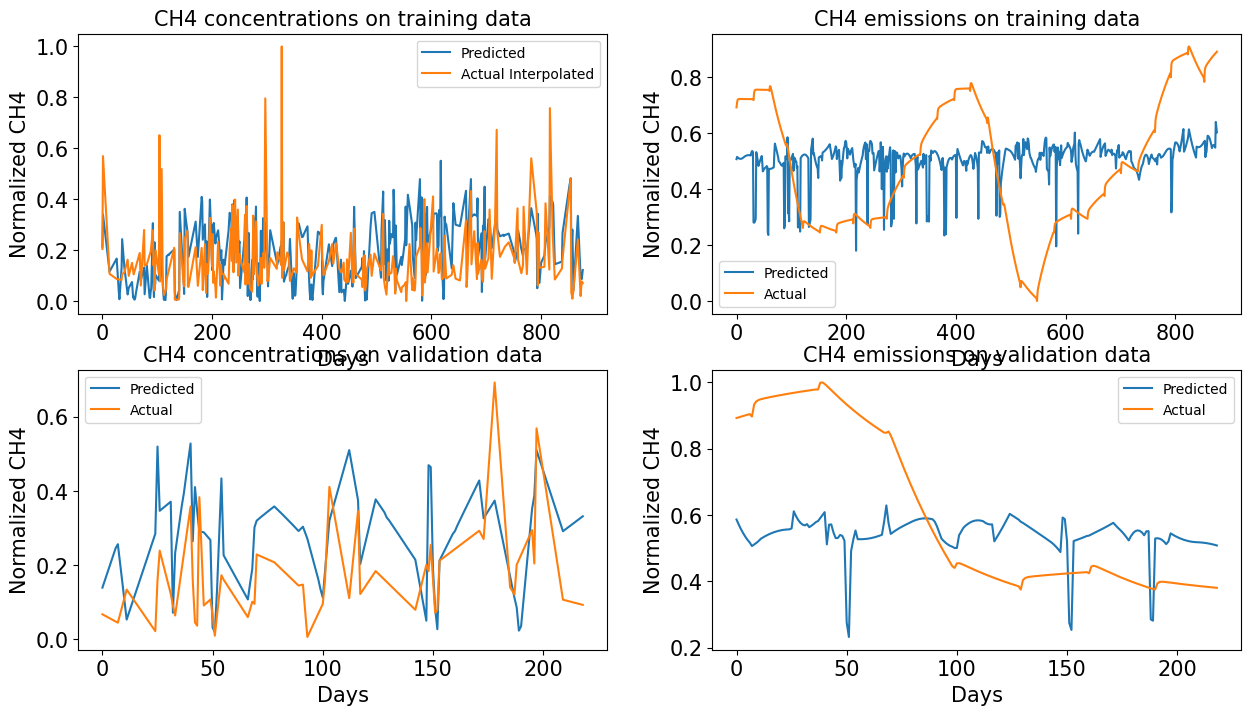

In [35]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.plot(conc_train6.detach().numpy(), label='Predicted')
plt.plot(ch4_conc_train.numpy(), label='Actual Interpolated')
plt.legend()
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.title('CH4 concentrations on training data',fontsize=15)
 
plt.subplot(2,2,2)
plt.plot(emm_train6.detach().numpy()[:], label='Predicted')
plt.plot(ch4_emm.numpy()[:], label='Actual')
plt.legend()
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.title('CH4 emissions on training data',fontsize=15)

plt.subplot(2,2,3)
plt.plot(conc_val6.detach().numpy(), label='Predicted')
plt.plot(ch4_conc_val.numpy(), label='Actual')
plt.legend()
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title('CH4 concentrations on validation data',fontsize=15)

plt.subplot(2,2,4)
plt.plot(emm_val6.detach().numpy(), label='Predicted')
plt.plot(ch4_emm_val.numpy(), label='Actual')
plt.legend()
plt.xlabel('Days',fontsize=15)
plt.ylabel('Normalized CH4',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
# plt.ylim(0.8,1.05)
plt.title('CH4 emissions on validation data',fontsize=15)

plt.show()

TEST FOR 2023

275 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 48, 49, 50, 52, 53, 54, 55, 56, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 103, 104, 105, 106, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 156, 157, 158, 159, 160, 161, 163, 165, 166, 171, 172, 173, 174, 175, 176, 178, 179, 181, 184, 185, 187, 190, 191, 196, 197, 198, 199, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 214, 215, 216, 219, 220, 221, 222, 223, 224, 226, 228, 230, 231, 232, 233, 236, 237, 238, 239, 240, 241, 242, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 268, 269, 272, 273, 274, 275, 276, 277, 2

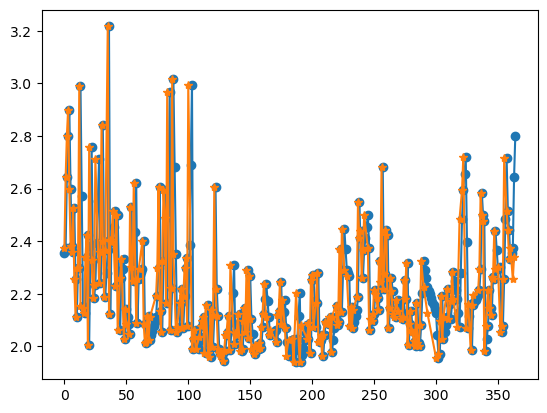

In [40]:
#1465: for syncrude
#1461: for suncor
# range for 2021 = 730:1094 else 2023 is 1465: and for 2020 365 730
diluent_syncrude2023 = np.array(df_syncrude.iloc[0:])[1465:,1:var] #+ noise*np.random.normal(0,0.005,(366,var))

dim2023 = diluent_syncrude.shape[1]
num_data2023 = diluent_syncrude.shape[0]-1


ch4_mat_full2023 = perc*(np.array(df_syncrude.iloc[0:])[1465:,21]).reshape(-1,1)
diluent_full2023 = perc*np.array(diluent_syncrude2023)

# print('diluent full shape', diluent_full2023.shape,'\nShape of full ch4',ch4_mat_full2023.shape)

dataset2023_true,xdays2023_true = station(station_wbea,'2023')
# dataset2023_true,xdays2023_true = station('Buffalo','2023')
# print('shape of available dataset is',dataset2023.shape)


# xdays2023 = list(np.array(data_wbea)[348:,1]-int(np.array(data_wbea)[348,1])) #31 #np.arange(dataset.shape[0])
print(len(xdays2023_true),xdays2023_true,diluent_full2023.shape)

if interpolate == True:
    x2023 = np.array(xdays2023_true)
    y2023 = np.zeros([dataset2023_true.shape[0],dataset2023_true.shape[1]])
    xx2023 = np.linspace(0,364,365)
    dataset_inter2023 = np.zeros((365,dataset2023_true.shape[1]))
    for i in range(dataset_true.shape[1]):
        y2023[:,i] = np.array(dataset2023_true)[:,i]
#         dataset_inter[:,i] = np.interp(xx, x, y[:,i])
    spl = BSpline(x2023, y2023, 1,extrapolate = 'periodic')
    dataset_inter2023 = spl(xx2023) 
    
    dataset2023 = dataset_inter2023
    xdays2023 = list(np.arange(len(xx2023))[:])
else:
    dataset2023 = dataset_true
    xdays2023 = xdays2023_true

plt.plot(dataset2023[:,0],'-o',label = 'interpolated')
plt.plot(xdays2023_true,dataset2023_true[:,0],'-*',label = 'true')

In [41]:
diluent2023 = diluent_full2023[:,:]
print(diluent_full.shape)
wbea_pars2023 = dataset2023[:,1:]
ch4_wbea2023 = dataset2023[:,0]
ch4_mat2023 = ch4_mat_full2023[xdays2023,:].astype('float32')
print(ch4_mat2023.shape,ch4_wbea2023.shape)
#create input data
inp2023 = torch.from_numpy(wbea_pars2023.astype('float32'))
# print(inp2023,diluent2023)
input_data2023 = torch.concatenate((inp2023,torch.tensor(diluent2023.astype('float32'))),dim = 1) # uses real or 2nd gen diluent data
print(inp.shape)

#scale the input data
scale_inp = np.linalg.norm(input_data2023[:,:],axis=0)
# input_data[:,:]/=scale_inp

inp_min = torch.min(input_data2023,dim=0)[0]
inp_max = torch.max(input_data2023,dim=0)[0]
input_data2023 = (input_data2023 - inp_min)/(inp_max-inp_min)


#create output data for concentrations taken from real data from WBEA
ch4_conc_data2023 = percentage*torch.from_numpy(ch4_wbea2023.reshape(-1,1).astype('float32')).reshape(-1,1)

    
scale_out = torch.norm(ch4_conc_data)
out_min = torch.min(ch4_conc_data2023)
out_max = torch.max(ch4_conc_data2023)
ch4_conc_data2023 = (ch4_conc_data2023 - out_min)/(out_max-out_min)
# plt.plot(ch4_conc_data2023)

#create output data for emissions taken from MM
ch4_emm_data2023 = torch.Tensor(ch4_mat2023).reshape(-1,1) #+ np.random.normal(0,0.005,(347,1)) #uses solved ch4 values from MATLAB of 2nd gen model
# plt.plot(ch4_emm_data2023)
scale_emm_data = torch.norm(ch4_emm_data)
ch4_min = torch.min(ch4_emm_data2023)
ch4_max = torch.max(ch4_emm_data2023)
ch4_emm_data2023 = (ch4_emm_data2023 - ch4_min)/(ch4_max-ch4_min)

time_data2023 = np.array(xdays2023).reshape(-1,1) #np.arange(1, len(input_data)+1).reshape(-1, 1)

# Convert time_data to a PyTorch tensor and normalize
time_data2023 = torch.tensor(time_data2023, dtype=torch.float32)
scale_time_data2023 = torch.norm(time_data2023)
time_data2023 /= scale_time_data2023

input_data2023 = input_data2023.requires_grad_(True)
time_data2023 = time_data2023.requires_grad_(True)


(1097, 19)
(365, 1) (365,)
torch.Size([1097, 15])


In [43]:
conc1_2023, emm1_2023 = model_forward(input_data2023, time_data2023)
conc2_2023, emm2_2023 = model_reverse(input_data2023, time_data2023)
conc3_2023, emm3_2023 = model_nn(input_data2023, time_data2023)
conc4_2023, emm4_2023 = one_connect(input_data2023, time_data2023)
conc5_2023, emm5_2023 = model_LSTM(input_data2023, time_data2023)
conc6_2023, emm6_2023 = model_polydict(input_data2023, time_data2023)




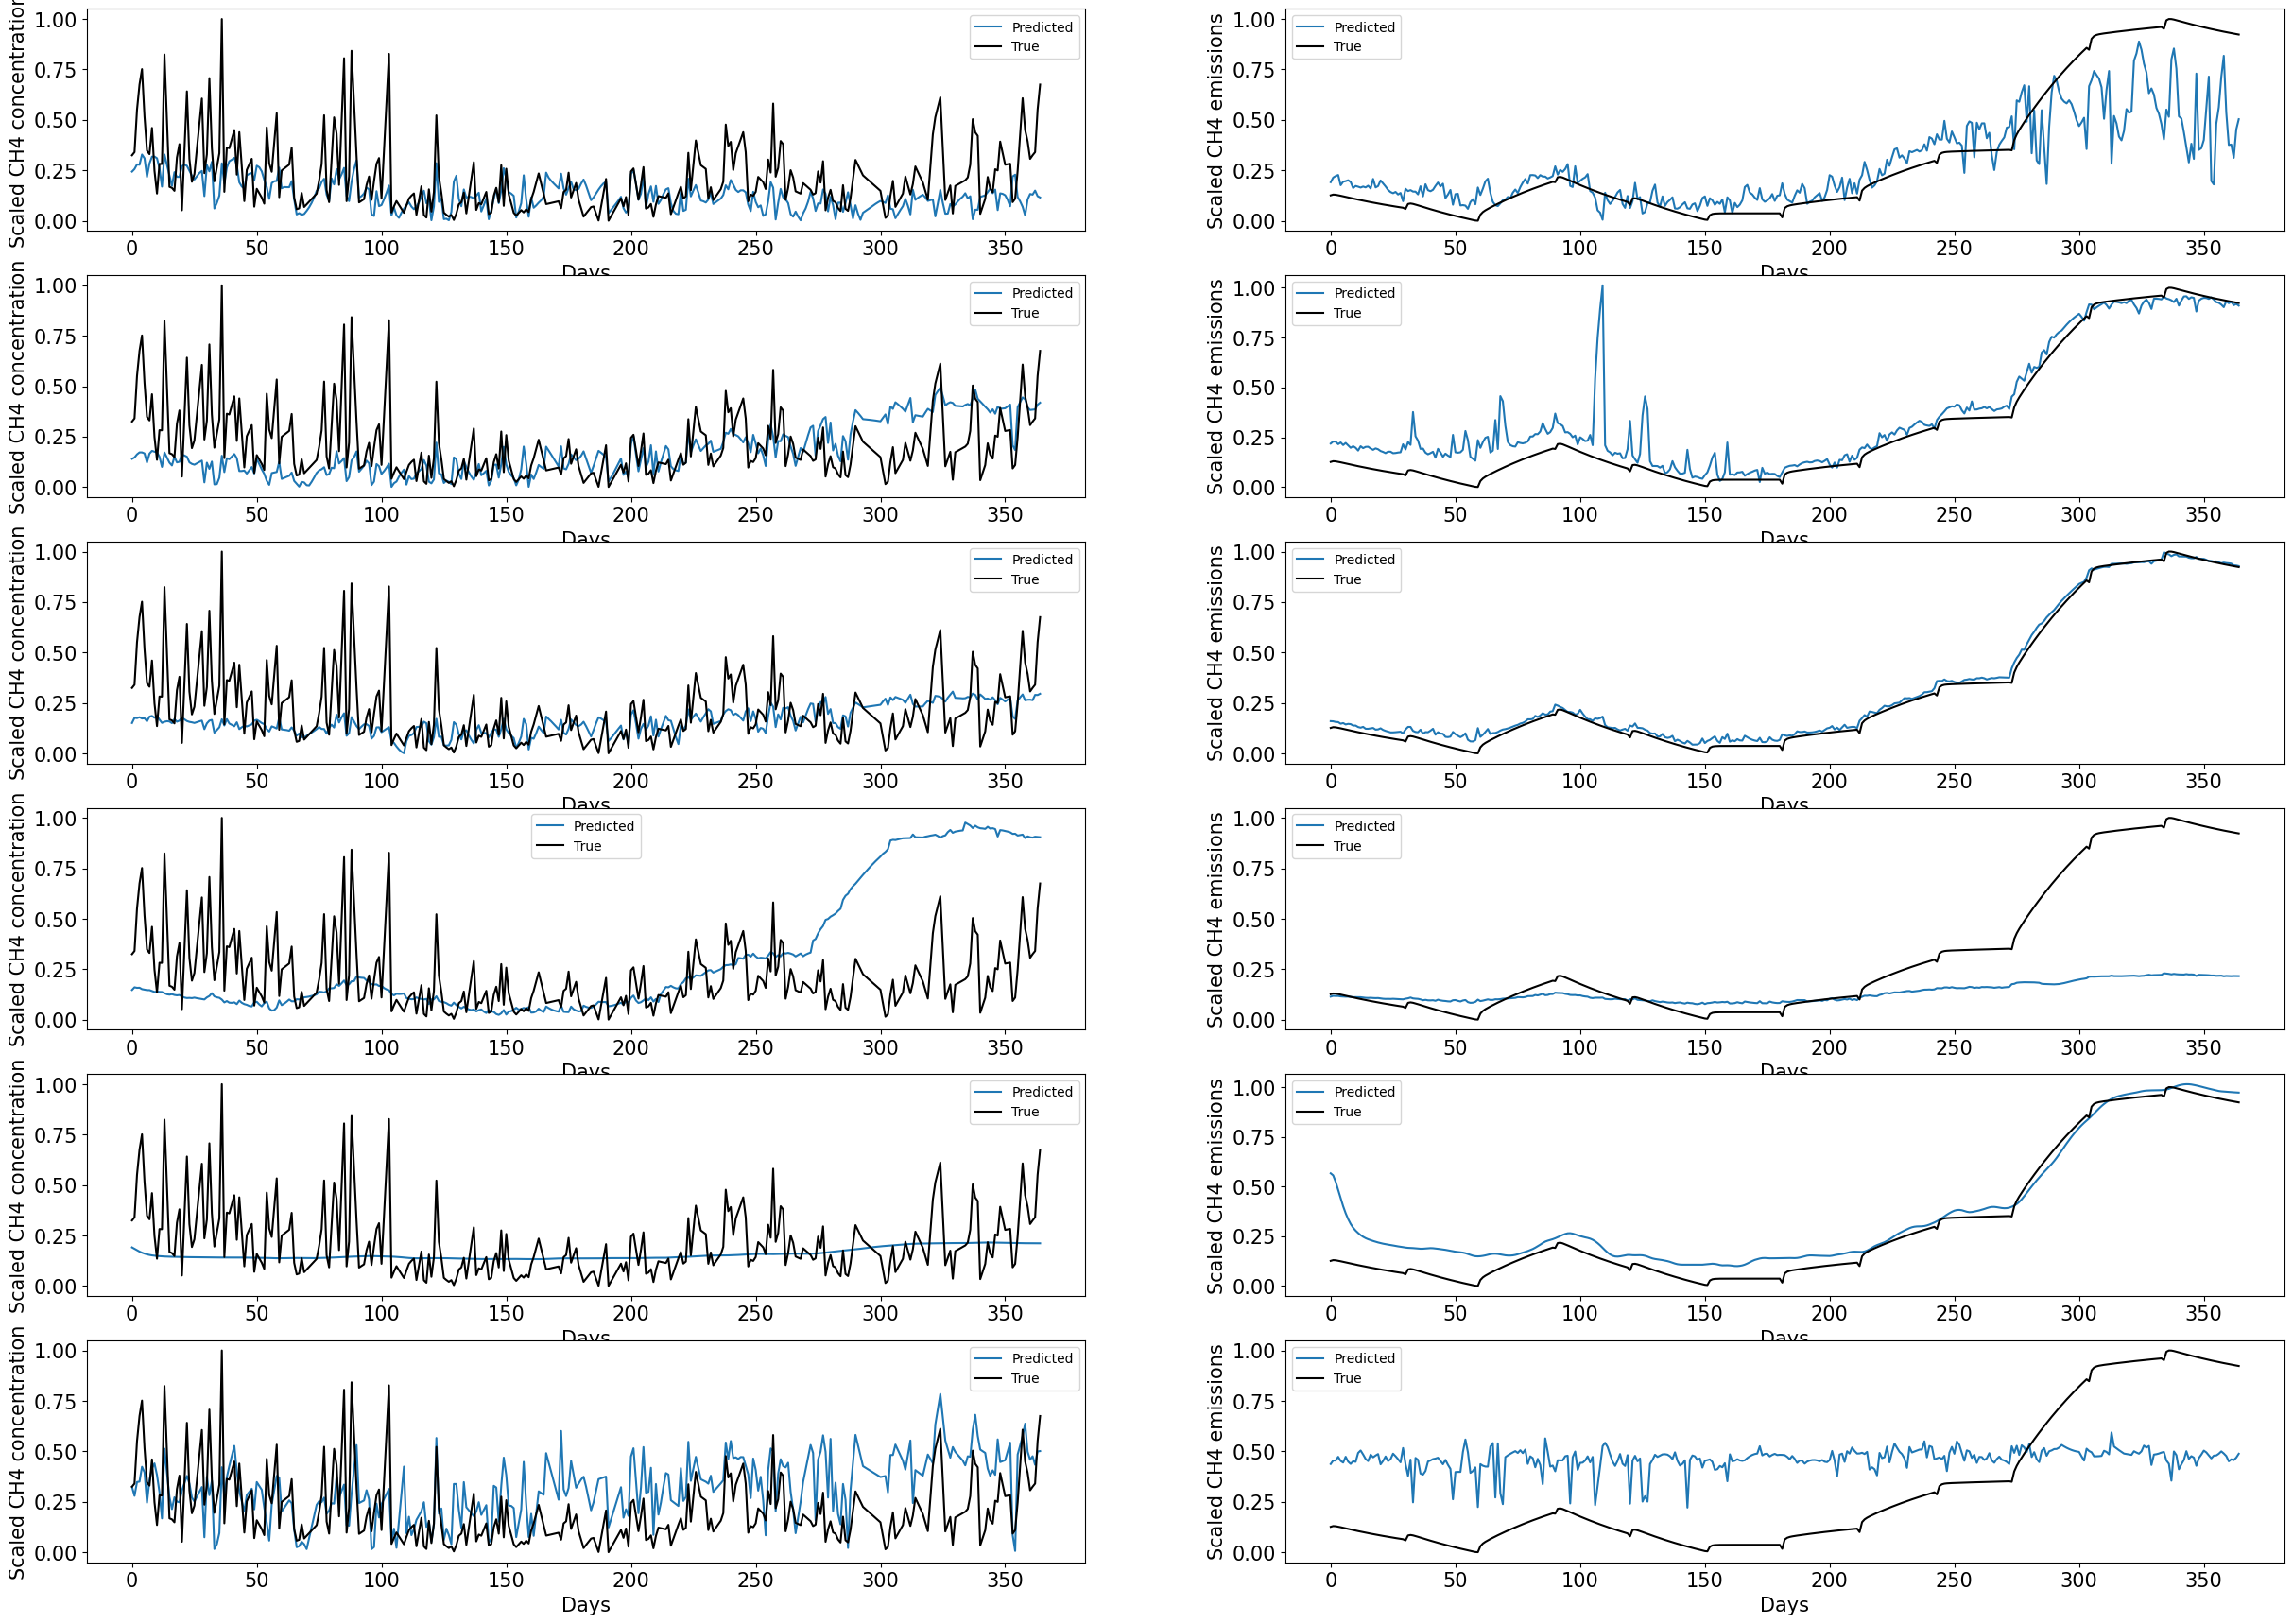

In [45]:
plt.figure(figsize=(30,25))
plt.subplot(7,2,1)
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),conc1_2023.detach().numpy(),label = 'Predicted')
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),ch4_conc_data2023.detach().numpy(),'k',label = 'True')
plt.xlabel('Days',fontsize=15)
plt.ylabel('Scaled CH4 concentration',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend()
# plt.title('Predicted CH4 concentrations ',fontsize=15)

plt.subplot(7,2,2)
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),emm1_2023.detach().numpy(),label = 'Predicted')
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),ch4_emm_data2023,'k',label = 'True')
# plt.title('Normalized CH4 emissions on validation data',fontsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Scaled CH4 emissions',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend()

#-------------------------------
plt.subplot(7,2,3)
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),conc2_2023.detach().numpy(),label = 'Predicted')
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),ch4_conc_data2023.detach().numpy(),'k',label = 'True')
plt.xlabel('Days',fontsize=15)
plt.ylabel('Scaled CH4 concentration',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend()
# plt.title('CH4 concentrations on validation data',fontsize=15)

plt.subplot(7,2,4)
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),emm2_2023.detach().numpy(),label = 'Predicted')
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),ch4_emm_data2023,'k',label = 'True')
# plt.title('Normalized CH4 emissions on validation data',fontsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Scaled CH4 emissions',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend()
#--------------------------------------
plt.subplot(7,2,5)
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),conc3_2023.detach().numpy(),label = 'Predicted')
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),ch4_conc_data2023.detach().numpy(),'k',label = 'True')
plt.xlabel('Days',fontsize=15)
plt.ylabel('Scaled CH4 concentration',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend()
# plt.title('CH4 concentrations on validation data',fontsize=15)

plt.subplot(7,2,6)
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),emm3_2023.detach().numpy(),label = 'Predicted')
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),ch4_emm_data2023,'k',label = 'True')
# plt.title('Normalized CH4 emissions on validation data',fontsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Scaled CH4 emissions',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend()

#-------------------------------
plt.subplot(7,2,7)
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),conc4_2023.detach().numpy(),label = 'Predicted')
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),ch4_conc_data2023.detach().numpy(),'k',label = 'True')
plt.xlabel('Days',fontsize=15)
plt.ylabel('Scaled CH4 concentration',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend()
# plt.title('CH4 concentrations on validation data',fontsize=15)

plt.subplot(7,2,8)
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),emm4_2023.detach().numpy(),label = 'Predicted')
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),ch4_emm_data2023,'k',label = 'True')
# plt.title('Normalized CH4 emissions on validation data',fontsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Scaled CH4 emissions',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend()
#-------------------------------------
plt.subplot(7,2,9)
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),conc5_2023.detach().numpy(),label = 'Predicted')
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),ch4_conc_data2023.detach().numpy(),'k',label = 'True')
plt.xlabel('Days',fontsize=15)
plt.ylabel('Scaled CH4 concentration',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend()
# plt.title('CH4 concentrations on validation data',fontsize=15)

plt.subplot(7,2,10)
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),emm5_2023.detach().numpy(),label = 'Predicted')
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),ch4_emm_data2023,'k',label = 'True')
# plt.title('Normalized CH4 emissions on validation data',fontsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Scaled CH4 emissions',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend()
#-----------------------------------------
plt.subplot(7,2,11)
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),conc6_2023.detach().numpy(),label = 'Predicted')
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),ch4_conc_data2023.detach().numpy(),'k',label = 'True')
plt.xlabel('Days',fontsize=15)
plt.ylabel('Scaled CH4 concentration',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend()
# plt.title('CH4 concentrations on validation data',fontsize=15)

plt.subplot(7,2,12)
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),emm6_2023.detach().numpy(),label = 'Predicted')
plt.plot((time_data2023*scale_time_data2023).detach().numpy(),ch4_emm_data2023,'k',label = 'True')
# plt.title('Normalized CH4 emissions on validation data',fontsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Scaled CH4 emissions',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend()


In [48]:
error1_conc2023, error1_emm2023 = error_rel(conc1_2023.detach(),emm1_2023.detach(),ch4_conc_data2023,ch4_emm_data2023)
error2_conc2023, error2_emm2023 = error_rel(conc2_2023.detach(),emm2_2023.detach(),ch4_conc_data2023,ch4_emm_data2023)
error3_conc2023, error3_emm2023 = error_rel(conc3_2023.detach(),emm3_2023.detach(),ch4_conc_data2023,ch4_emm_data2023)
error4_conc2023, error4_emm2023 = error_rel(conc4_2023.detach(),emm4_2023.detach(),ch4_conc_data2023,ch4_emm_data2023)
error5_conc2023, error5_emm2023 = error_rel(conc5_2023.detach(),emm5_2023.detach(),ch4_conc_data2023,ch4_emm_data2023)
error6_conc2023, error6_emm2023 = error_rel(conc6_2023.detach(),emm6_2023.detach(),ch4_conc_data2023,ch4_emm_data2023)

print('CHAMP Forward 2023',error1_conc2023, error1_emm2023)
print('CHAMP Reverse 2023',error2_conc2023, error2_emm2023)
print('NN 2023',error3_conc2023, error3_emm2023)
print('1 connect 2023',error4_conc2023, error4_emm2023)
print('LSTM 2023',error5_conc2023, error5_emm2023)
print('Spa Dict 2023',error6_conc2023, error6_emm2023)

CHAMP Forward 2023 tensor(0.6287) tensor(0.4370)
CHAMP Reverse 2023 tensor(0.6910) tensor(0.2484)
NN 2023 tensor(0.6177) tensor(0.0652)
1 connect 2023 tensor(1.3167) tensor(0.7390)
LSTM 2023 tensor(0.6380) tensor(0.1936)
Spa Dict 2023 tensor(0.7600) tensor(0.7815)
